In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


$\mathcal{L} = \exp(-\lambda) \frac{1}{n!} \lambda ^n$ \
for easier minimalisation: \
$-2 \log (\mathcal{L})= - 2 n \log (\lambda) + 2 \lambda $

In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map,MapAxis
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#from my_dataset_maps_20_e import MapDatasetNuisanceE gets imported in Dataset_Creation!
#from  my_fit_20 import Fit
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Eff_area"
)
import my_dataset_core_20_e , my_fit_20_e
from Dataset_Creation_e_dependent import sys_dataset

In [3]:
from  my_fit_20_e import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    parameters = Parameters.from_stack([datasets_compute.models.parameters, 
                                        datasets_compute.N_parameters])
    parameters = parameters.free_parameters
    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : _kiSh2dT 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

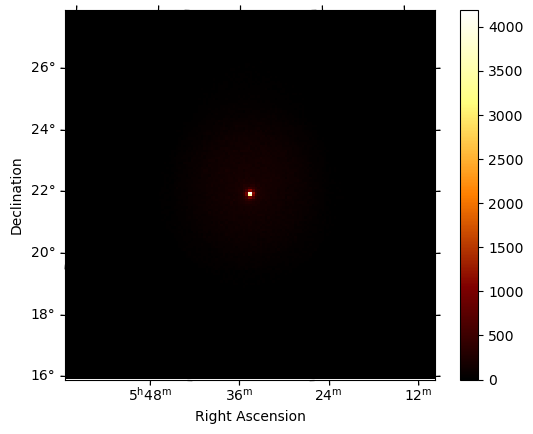

In [4]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_load.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_load.models = models

dataset_asimov = dataset_load.copy()
dataset_asimov.counts = dataset_load.npred()
models = Models(source_model.copy(name="Source"))
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_load.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_load.geoms["geom"].width[1] / dataset_load.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_load)

## Asimov Cases

In [5]:
tilt_neg =0.08/24 # 4e-3
tilt_pos = -tilt_neg
tilt_cor = 0

shift_neg = 0.1
shift_pos = -0.1
shift_cor = 0.0

#N_parameter1 = Parameter(name = "effareashift", value = 0, frozen = True)
#N_parameter2 = Parameter(name = "effareatilt", value = 0, frozen = True)

sigma = [ tilt_neg, shift_neg]

In [6]:
sys_d_cor = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_cor, 
                        shift = shift_cor,
                        rnd =  False)
dataset_cor_N = sys_d_cor.create_dataset_N(sigma)

sys_d_neg = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_neg, 
                        shift = shift_neg,
                        rnd =  False)
dataset_neg_N = sys_d_neg.create_dataset_N(sigma)

sys_d_pos = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_pos, 
                        shift = shift_pos,
                        rnd =  False)
dataset_pos_N = sys_d_pos.create_dataset_N(sigma)



In [7]:
def compute_error(fit, dataset):
    if dataset.N_parameters[0].frozen == False:
        covariance  = covariance_(fit, dataset)
        eff_area_error = np.sqrt(covariance.get_subcovariance([dataset.N_parameters[0]]))
        dataset.N_parameters[0].error = eff_area_error
    if dataset.N_parameters[1].frozen == False:
        eff_area_error = np.sqrt(covariance.get_subcovariance([dataset.N_parameters[1]]))
        dataset.N_parameters[1].error = eff_area_error

type     name       value    unit   error   min max frozen is_norm link
---- ------------ ---------- ---- --------- --- --- ------ ------- ----
None  effareatilt 0.0000e+00      0.000e+00 nan nan  False   False     
None effareashift 0.0000e+00      0.000e+00 nan nan  False   False     
-751797.4912337466


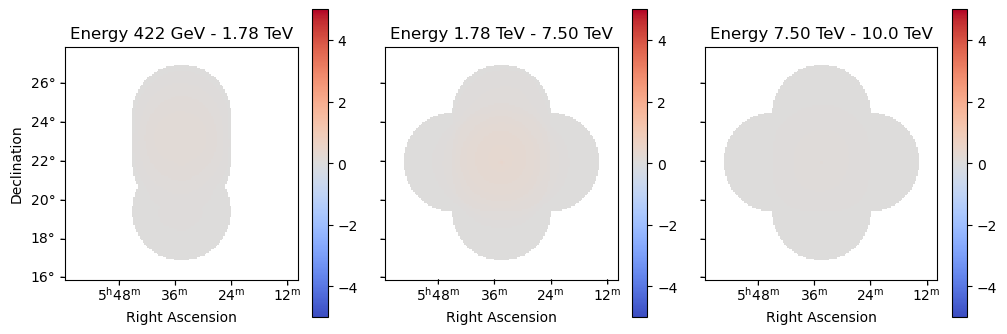

In [8]:
slices = {"energy": slice(5,20,5)} #to get the first 3 energy slices
dataset_pos_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",
                                                                            add_cbar=True, vmin=-5, vmax=5,)
print(dataset_pos_N.N_parameters.to_table())
print(dataset_pos_N.stat_sum())

In [9]:
'''#dataset_pos_N.N_parameters[0].value = factor_neg
#dataset_pos_N.N_parameters[1].value = tilt_neg

dataset_pos_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",
                                                                            add_cbar=True, vmin=-5, vmax=5,)
print(dataset_pos_N.N_parameters.to_table())
print(dataset_pos_N.stat_sum())
#dataset_pos_N.N_parameters[0].value = 0
#dataset_pos_N.N_parameters[1].value = 0
print(dataset_pos_N.stat_sum())'''

'#dataset_pos_N.N_parameters[0].value = factor_neg\n#dataset_pos_N.N_parameters[1].value = tilt_neg\n\ndataset_pos_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",\n                                                                            add_cbar=True, vmin=-5, vmax=5,)\nprint(dataset_pos_N.N_parameters.to_table())\nprint(dataset_pos_N.stat_sum())\n#dataset_pos_N.N_parameters[0].value = 0\n#dataset_pos_N.N_parameters[1].value = 0\nprint(dataset_pos_N.stat_sum())'

In [10]:
%%time
print("corr")
fit_cor = my_fit_20_e.Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor_N])
compute_error(fit_cor, dataset_cor_N)   

print("neg")
fit_neg = my_fit_20_e.Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg_N])
compute_error(fit_neg, dataset_neg_N)   

print("pos")
fit_pos = my_fit_20_e.Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos_N])
compute_error(fit_pos, dataset_pos_N)   


corr
neg
pos
CPU times: user 2min 40s, sys: 14.9 s, total: 2min 55s
Wall time: 2min 56s


In [11]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
    
    
print("Best Fit bkg Tilt")
tilts_N = []
value = dataset_asimov.background_model.parameters['tilt'].value 
error = dataset_asimov.background_model.parameters['tilt'].error
tilts_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['tilt'].value 
    error = d.background_model.parameters['tilt'].error
    print(f'{value} pm {error}')
    tilts_N.append((value, error))
    

best fit amplitude
====
Input
1e-12 pm 0.0
====
9.311925292258247e-13 pm 8.294498117186196e-14
1e-12 pm 8.520320156007707e-14
1.0820123590050374e-12 pm 1.00116642187241e-13

best fit Index
====
Input
2.3 pm 0.0
====
2.289602902014083 pm 0.061543887057020755
2.3 pm 0.058557873606924986
2.312954136142448 pm 0.0634417764051515

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9313004578804535 pm 0.09616422266270495
1.0 pm 0.0067344247702683605
1.042234019887435 pm 0.017771993838115018
Best Fit bkg Tilt
====
Input
0.0 pm 0
====
-0.010903129051556996 pm 0.011548055254472042
0.0 pm 0.00658256184876925
0.01260032377756946 pm 0.011089745933193243


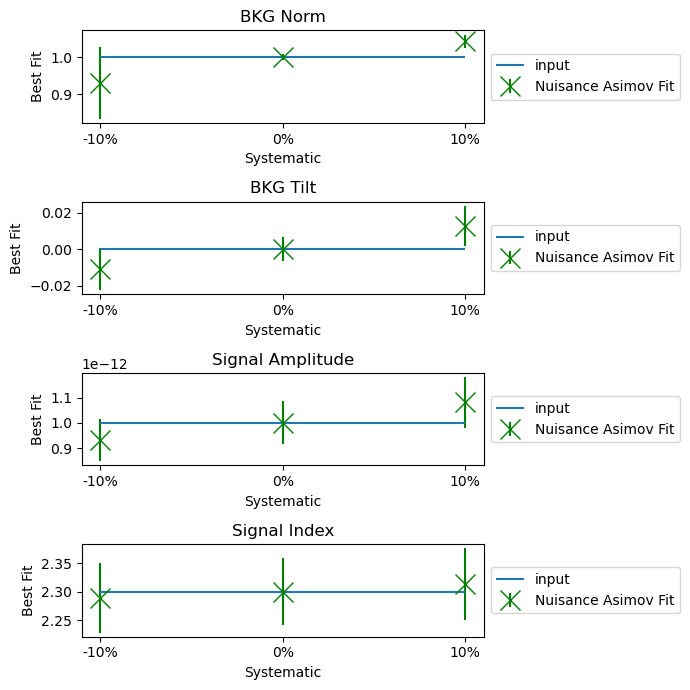

In [12]:
fig, axs = plt.subplots(4,1, figsize = (7,7))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(tilts_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( tilts_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines( indices_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


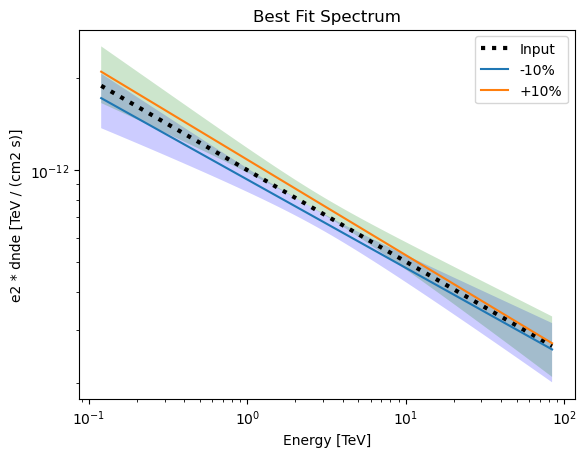

In [13]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

#dataset_cor_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
#                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

-1.241504822098899e-06
-0.0011865973663688879
0.0
0.0
-7.557262039297938e-05
0.03666701123618956


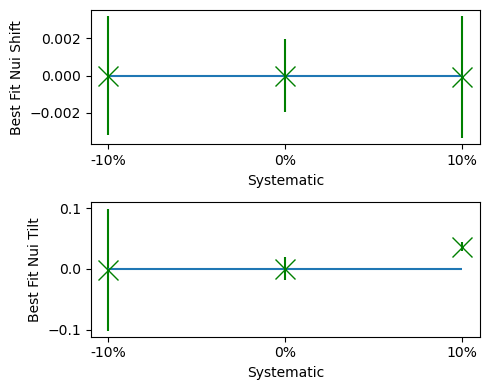

In [14]:
fig, a  = plt.subplots(2,1 , figsize = (5,4))
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
    value = d.N_parameters[0].value
    error = d.N_parameters[0].error
    print(value)
    
    a[0].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                   label = label)
    #a[0].text(iss[i],-0.05, f'{value:.2}', )
    
    value = d.N_parameters[1].value
    error = d.N_parameters[1].error
    print(value)
    
    a[1].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color =  'green',markersize=14,
                   label = label)
    #a[1].text(iss[i],-0.05, f'{value:.2}', )
a[0].hlines( 0., 1, 3, label = "input")

plt.tight_layout()
a[0].set_ylabel('Best Fit Nui Shift'); 
a[0].set_xlabel('Systematic'); 
a[0].set_xticks(np.arange(3)+1,labels_sys);

a[1].hlines( 0., 1, 3, label = "input")
a[1].set_ylabel('Best Fit Nui Tilt'); 
a[1].set_xlabel('Systematic'); 
a[1].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
fig.savefig("plots/2_best_fit_nui.pdf")

## Multiple Poission Draws

In [16]:
N = 10
datasets_cor_N = []
datasets_neg_N = []
datasets_pos_N = []

sys_d_cor_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_cor, 
                        shift = shift_cor,
                        rnd =  True)
sys_d_neg_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_neg, 
                        shift = shift_neg,
                        rnd =  True)
sys_d_pos_rnd = sys_dataset(dataset_asimov = dataset_asimov,
                        tilt = tilt_pos, 
                        shift = shift_pos,
                        rnd =  True)


for n in range(N):
    datasets_cor_N.append(sys_d_cor_rnd.create_dataset_N(sigma))
    datasets_neg_N.append(sys_d_neg_rnd.create_dataset_N(sigma))
    datasets_pos_N.append(sys_d_pos_rnd.create_dataset_N(sigma))


In [17]:
%%time
fitting_poission_draws = False
if fitting_poission_draws:
    print("Corr")
    for i, d in enumerate(datasets_cor_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        covariance  = covariance_(fit_cor, d)
        eff_area_error = np.sqrt(covariance.get_subcovariance([d.N_parameters[0]]))
        d.N_parameters[0].error = float(eff_area_error)
        
    print("Neg")
    for i, d in enumerate( datasets_neg_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        covariance  = covariance_(fit_cor, d)
        eff_area_error = np.sqrt(covariance.get_subcovariance([d.N_parameters[0]]))
        d.N_parameters[0].error = float(eff_area_error)
    print("Pos")
    for i, d in enumerate (datasets_pos_N):
        print(i)
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([d])
        covariance  = covariance_(fit_cor, d)
        eff_area_error = np.sqrt(covariance.get_subcovariance([d.N_parameters[0]]))
        d.N_parameters[0].error = float(eff_area_error)
        
        
    amplitudes_all_N = []
    indices_all_N = []
    norms_all_N = []
    N_all_N= []

    datasets_p = [datasets_neg_N, datasets_cor_N, datasets_pos_N]
    for d_case in datasets_p:
        print("best fit amplitude")
        amplitudes_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['amplitude'].value 
            error = m.parameters['amplitude'].error
            amplitudes_p.append((value, error))
            print(f'{value} pm {error}')
        print()
        print("best fit Index")
        indices_p = []
        print('====')
        for d in d_case:
            m = d.models['Source']
            value = m.parameters['index'].value 
            error = m.parameters['index'].error
            indices_p.append((value, error))
            print(f'{value} pm {error}')
        print()

        print("Best Fit bkg Norm")
        norms_p = []
        print('====')
        for d in d_case:
            value = d.background_model.parameters['norm'].value 
            error = d.background_model.parameters['norm'].error
            print(f'{value} pm {error}')
            norms_p.append((value, error))
            
        print("Nuisance Parameters")
        N_p = []
        print('====')
        for d in d_case:
            value = d.N_parameters[0].value 
            error = d.N_parameters[0].error
            print(f'{value} pm {error}')
            N_p.append((value, error))


        amplitudes_all_N.append(amplitudes_p)
        indices_all_N.append(indices_p)
        norms_all_N.append(norms_p)
        N_all_N.append(N_p)   

    with open('data/norms_all_N.yaml', 'w') as file:
        documents = yaml.dump(norms_all_N, file)
    with open('data/amplitudes_all_N.yaml', 'w') as file:
        documents = yaml.dump(amplitudes_all_N, file)
    with open('data/indices_all_N.yaml', 'w') as file:
        documents = yaml.dump(indices_all_N, file)
    with open('data/N_all_N.yaml', 'w') as file:
        documents = yaml.dump(N_all_N, file)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [ ]:
'''if fitting_poission_draws ==False:
    with open('data/norms_all_N.yaml') as file:
        norms_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/amplitudes_all_N.yaml') as file:
        amplitudes_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/indices_all_N.yaml') as file:
        indices_all_N = yaml.load( file, Loader=yaml.FullLoader)
    with open('data/N_all_N.yaml') as file:
        N_all_N = yaml.load( file, Loader=yaml.FullLoader)
'''

## Comparison

In [18]:
with open('data/norms_all.yaml') as file:
    norms_all = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes_all.yaml') as file:
    amplitudes_all = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices_all.yaml') as file:
    indices_all = yaml.load( file, Loader=yaml.FullLoader)
with open('data/tilts_all.yaml') as file:
    tilts_all = yaml.load( file, Loader=yaml.FullLoader)

with open('data/norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
with open('data/tilts.yaml') as file:
    tilts = yaml.load( file, Loader=yaml.FullLoader)    


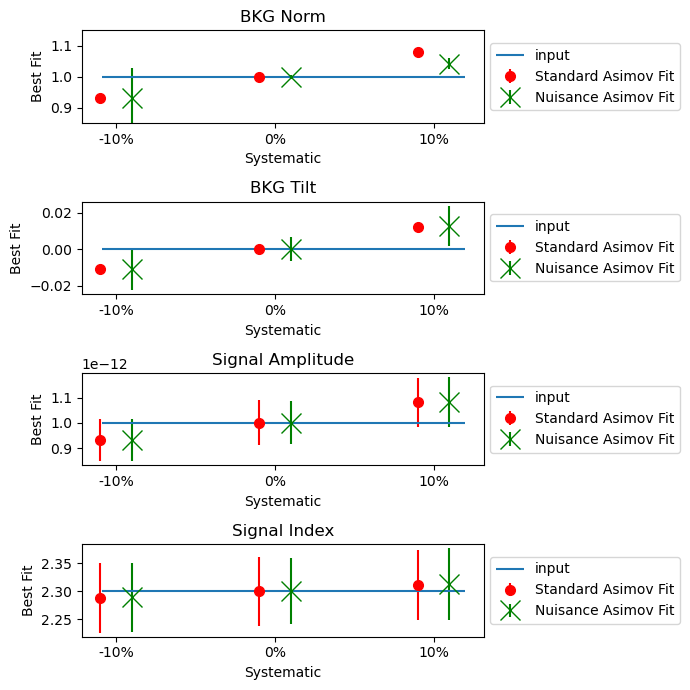

In [19]:
fig, axs = plt.subplots(4,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("BKG Tilt")
axs[2].set_title("Signal Amplitude")
axs[3].set_title("Signal Index")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(tilts[1:]):
    label = "Standard Asimov Fit"
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for j in range(3):
    label = "Standard Rnd Fit"
    for i, a in enumerate(norms_all[j][1:]):
        axs[0].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(tilts_all[j][1:]):
        axs[1].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(amplitudes_all[j][1:]):
        axs[2].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)
    for i, a in enumerate(indices_all[j][1:]):
        axs[3].errorbar(x= 0.95+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'orange',
                       label = label)

for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(tilts_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
'''        
for j in range(3):
    label = "Nuisance Rnd Fit"
    for i, a in enumerate(norms_all_N[j]):
        axs[0].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
    for i, a in enumerate(amplitudes_all_N[j]):
        axs[1].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
    for i, a in enumerate(indices_all_N[j]):
        axs[2].errorbar(x= 1.15+j+ i*0.01, y = a[0], yerr = a[1], fmt= 'x', color =  'lightgreen',
                       label = label)
'''        
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines(tilts[0][0], 0.91, 3.2, label = "input")
axs[2].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[3].hlines( indices[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [ ]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [ ]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=False,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models['Source'].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum.pdf")

## Residuals 

In [ ]:
slices = {"energy": slice(10, 13)} #to get the first 3 energy slices
dataset_cor_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",
                                                                            add_cbar=True, vmin=-5, vmax=5,)

In [ ]:
dataset_pos_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",
                                                                            add_cbar=True, vmin=-5, vmax=5,)

In [ ]:
dataset_neg_N.residuals("diff/sqrt(model)").slice_by_idx(slices).plot_grid(cmap="coolwarm",
                                                                            add_cbar=True, vmin=-5, vmax=5,)